In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import keras_tuner as kt

/usr/local/lib/python3.8/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
PATH = "Dataset"
MODEL = "CNN"

In [3]:
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'val')

In [4]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 7560 files belonging to 4 classes.


In [5]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 3240 files belonging to 4 classes.


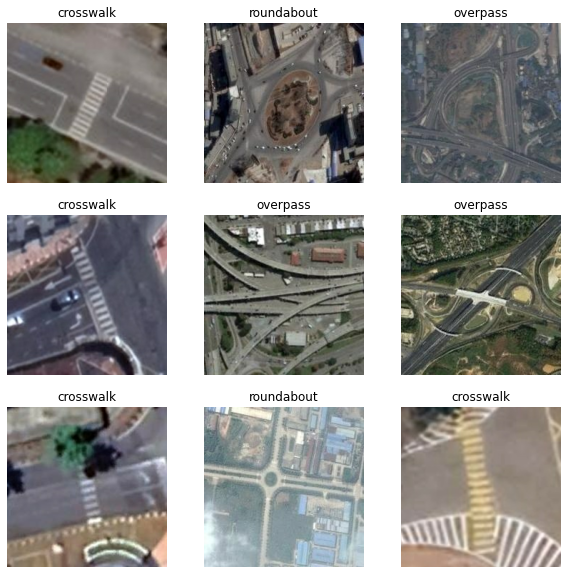

In [6]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [7]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 3)
validation_dataset = validation_dataset.skip(val_batches // 3)

In [8]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 68
Number of test batches: 34


In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [10]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

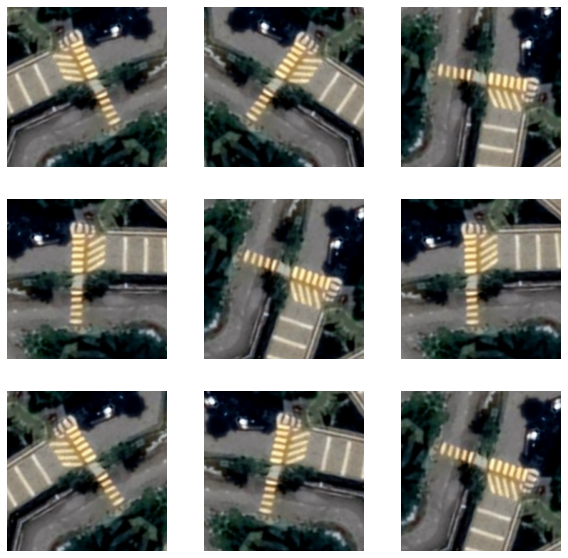

In [11]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [12]:
preprocess_input = tf.keras.applications.vgg19.preprocess_input

In [13]:
# Create custom CNN model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Rescaling, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Dense, Flatten


class CNNHyperModel(kt.HyperModel): 

    # Create class for hyperparameter tuning
    def build(self, hp): 

        model = Sequential()
        model.add(Rescaling(1./255, input_shape=(224,224,3)))
        model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(MaxPooling2D((2, 2)))
        model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2)))
        model.add(Dropout(0.2))
        model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(BatchNormalization())
        model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2)))
        model.add(Dropout(0.3))
        model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(BatchNormalization())
        model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2)))
        model.add(Dropout(0.4))
        model.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(BatchNormalization())
        model.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2)))
        model.add(Dropout(0.5))
        model.add(Flatten())
        model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
        model.add(BatchNormalization())
        model.add(Dropout(0.2))
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
        model.add(BatchNormalization())
        model.add(Dropout(0.2))
        model.add(Dense(4,activation='softmax'))

        # Tune the learning rate for the optimizer
        # Choose an optimal value from 0.01, 0.001, or 0.0001
        hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

        # compile model
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                    metrics=['accuracy'])

        return model
    
    def fit(self, hp, model, *args, **kwargs): 
        return model.fit(
            *args, 
            batch_size=hp.Choice("batch_size", [32, 64]),
            **kwargs
        )


In [14]:
tuner = kt.GridSearch(
    CNNHyperModel(), 
    objective="val_accuracy", 
    seed=0, 
    directory="CNN", 
    project_name="Custom_CNN"
)

In [15]:
# logging to tensorboard

from datetime import datetime

log_dir = f"logs/fit/{MODEL}_" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [16]:
tuner.search(train_dataset,
             epochs=50,
             validation_data=validation_dataset, 
             callbacks=[tensorboard_callback])

Trial 6 Complete [00h 04m 44s]
val_accuracy: 0.9214683771133423

Best val_accuracy So Far: 0.9512081742286682
Total elapsed time: 00h 28m 32s
INFO:tensorflow:Oracle triggered exit


In [17]:
best_model = tuner.get_best_models(1)[0]
best_model.build()
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      9248      
                                                                 
 batch_normalization (BatchN  (None, 112, 112, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0

In [18]:
tuner.results_summary()

Results summary
Results in CNN/Custom_CNN
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0002 summary
Hyperparameters:
learning_rate: 0.001
batch_size: 32
Score: 0.9512081742286682

Trial 0003 summary
Hyperparameters:
learning_rate: 0.001
batch_size: 64
Score: 0.946096658706665

Trial 0001 summary
Hyperparameters:
learning_rate: 0.01
batch_size: 64
Score: 0.9395910501480103

Trial 0000 summary
Hyperparameters:
learning_rate: 0.01
batch_size: 32
Score: 0.9279739856719971

Trial 0005 summary
Hyperparameters:
learning_rate: 0.0001
batch_size: 64
Score: 0.9214683771133423

Trial 0004 summary
Hyperparameters:
learning_rate: 0.0001
batch_size: 32
Score: 0.917286217212677


In [19]:
loss, accuracy = best_model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

34/34 [==============================] - 1s 8ms/step - loss: 0.2055 - accuracy: 0.9430
Test accuracy : 0.9430146813392639


34/34 [==============================] - 0s 8ms/step - loss: 0.1927 - accuracy: 0.9449
Test accuracy : 0.9448529481887817
Predictions:
 [2, 2, 2, 1, 3, 3, 0, 0, 0, 1, 0, 3, 1, 2, 1, 3, 2, 1, 2, 0, 0, 1, 1, 3, 1, 1, 0, 0, 0, 2, 3, 3]
Labels:
 [2 2 2 1 3 3 0 0 0 1 0 3 1 2 1 3 2 1 2 0 0 1 1 1 1 1 0 0 0 2 3 3]


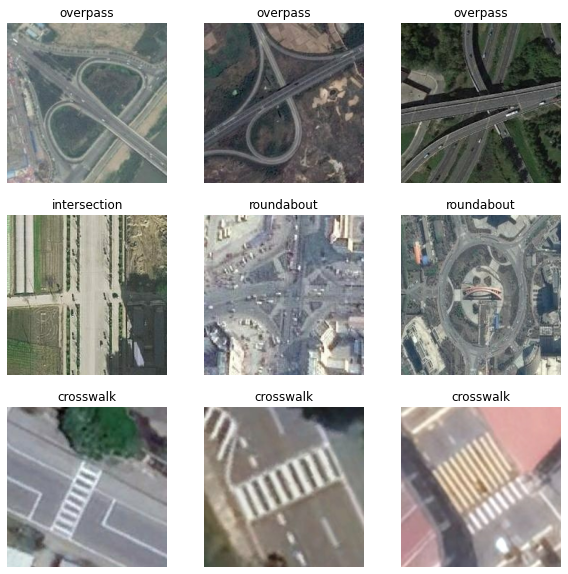

In [20]:
loss, accuracy = best_model.evaluate(test_dataset)
print('Test accuracy :', accuracy)
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = best_model.predict_on_batch(image_batch)

prediction_label = []
for prediction in predictions: 
    pred = max(prediction)
    prediction_label.append(prediction.tolist().index(pred))

# # Apply a sigmoid since our model returns logits
# predictions = tf.nn.sigmoid(predictions)
# predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', prediction_label)
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[prediction_label[i]])
  plt.axis("off")